In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path
from collections.abc import Iterable
from matplotlib.colors import LogNorm

In [2]:
datapath = Path.cwd() / "data"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

In [69]:
jobids = []
params = []
data_xx = []
data_zz = []
folder_xx = datapath/"xx"
folder_zz = datapath/"zz"
files_xx = ["7347408_N19_RS.jld2","7347409_N19_RS.jld2"]
files_zz = ["7365616_N19_RS.jld2","7365617_N19_RS.jld2"]
for (i,file) in enumerate(files_xx):
    with h5py.File(folder_xx/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_xx.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])

for (i,file) in enumerate(files_zz):
    with h5py.File(folder_zz/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data_zz.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])
#for  i in range(1,len(files)):
 #       data[i] = np.concatenate(data[i],axis=2)
#T = np.arange(0,2.01,0.01)

In [218]:
N = 19
T = 10 ** np.linspace(-3,1,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])

In [90]:
def model(x,a,b):
    return a*x**b

# ZZ Commutator

In [91]:
res_zz = data_zz[0][:,:,0]
res_zz_nn = data_zz[1][:,:,0]
red_zz = np.zeros((res_zz.shape[0],N//2+1))
red_zz_nn = np.zeros((res_zz.shape[0],N//2+1))

for j in range(0,N//2):
    red_zz[:,j] = 0.5*(res_zz[:,j]+res_zz[:,N-j-1])
    red_zz_nn[:,j] = 0.5*(res_zz_nn[:,j]+res_zz_nn[:,N-j-1])
red_zz[:,N//2] = res_zz[:,N//2]
red_zz_nn[:,N//2] = res_zz_nn[:,N//2]

In [92]:
popt = []
perr = []
tfitmax = [35,35,25,25,25,25,25,15]
tfitmin = [0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,8):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_zz[tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [93]:
popt_nn = []
perr_nn = []
tfitmax_nn = [65,65,60,60,55,55,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0]
for j in range(0,8):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_zz_nn[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_nn.append(poptj_nn)
    perr_nn.append(np.sqrt(np.diag(pcovj_nn)))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [94]:
tcut = np.zeros(8)
for j in range(0,8):
    tcut[j] = (popt[j][0]/popt_nn[j][0])**(1/(popt_nn[j][1]-popt[j][1]))
    print(tcut[j])

nan


/tmp/ipykernel_55151/1412608056.py:3: RuntimeWarning: invalid value encountered in double_scalars
  tcut[j] = (popt[j][0]/popt_nn[j][0])**(1/(popt_nn[j][1]-popt[j][1]))


IndexError: list index out of range

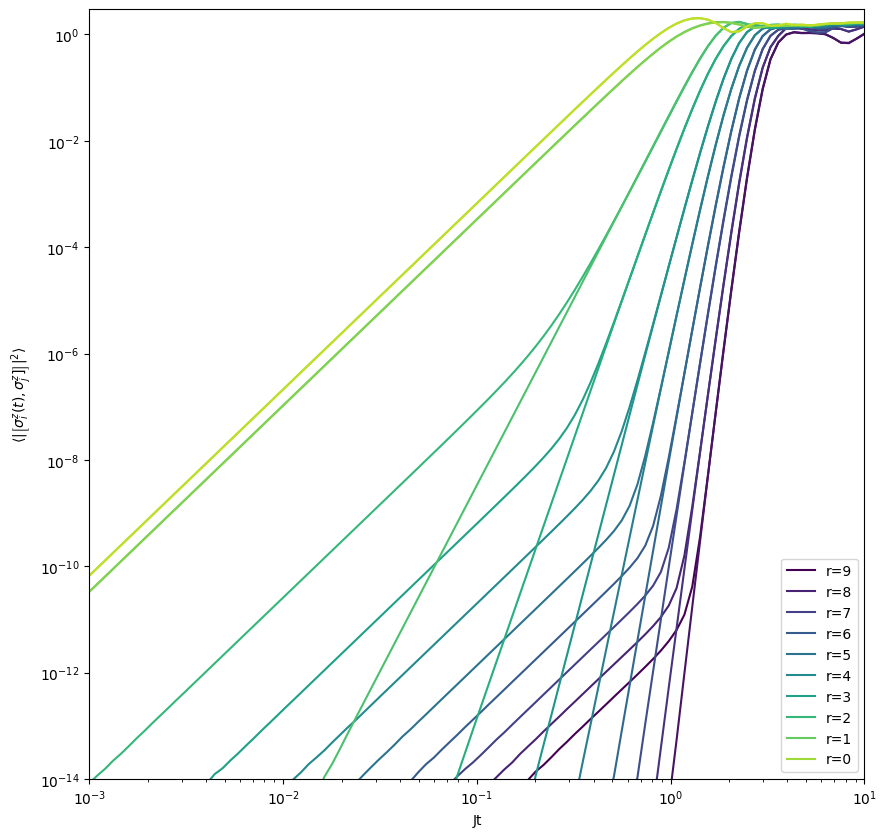

In [220]:
NUM_COLORS = N+2
cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax.set_xscale("log")
ax.set_yscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red_zz[:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_zz_nn[:,j])
    #if j <= 7:
    #    ax.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt[j][0],popt[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_nn[j][0],popt_nn[j][1]),color="black",alpha=0.8,ls="dashed")
    #    ax.scatter(tcut[j],model(tcut[j],popt[j][0],popt[j][1]),marker="x")
ax.legend(loc="lower right")
ax.set_xlabel("Jt")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_xlim(1e-3,10)
ax.set_ylim(1e-14,3)
plt.show()

# XX Commutator

In [96]:
res_xx = data_xx[0][:,:,0,0]
res_xx_nn = data_xx[1][:,:,0,0]
red_xx = np.zeros((res_xx.shape[0],N//2+1))
red_xx_nn = np.zeros((res_xx.shape[0],N//2+1))

for j in range(0,N//2):
    red_xx[:,j] = 0.5*(res_xx[:,j]+res_xx[:,N-j-1])
    red_xx_nn[:,j] = 0.5*(res_xx_nn[:,j]+res_xx_nn[:,N-j-1])
red_xx[:,N//2] = res_xx[:,N//2]
red_xx_nn[:,N//2] = res_xx_nn[:,N//2]

## Contour Plots

In [132]:
red_xx.shape

(100, 10)

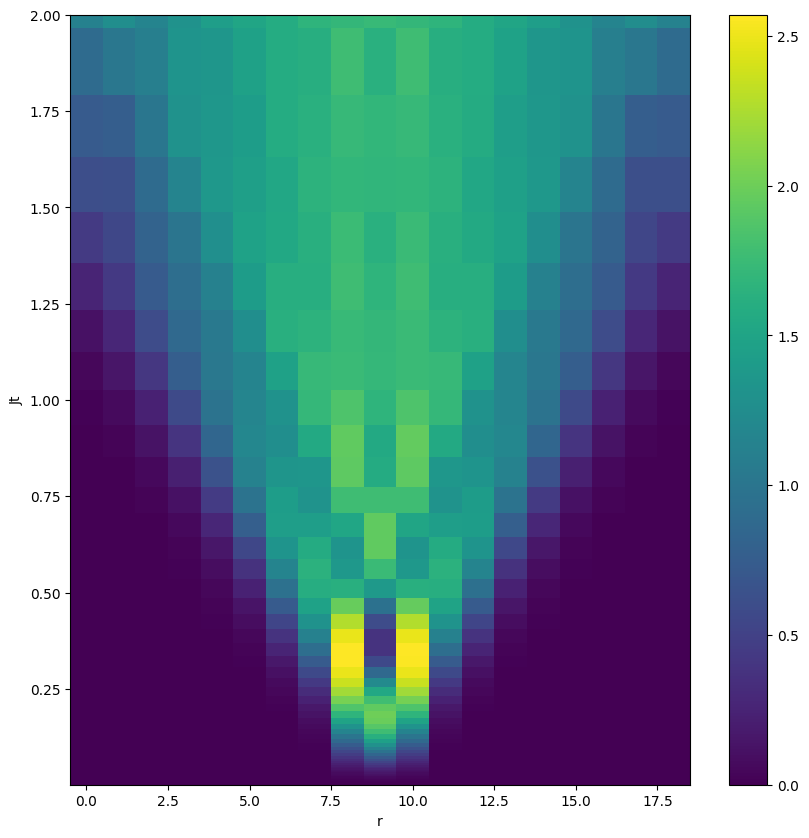

In [159]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.pcolormesh(range(0,N),T,res_xx)
fig.colorbar(im,ax=ax)
ax.autoscale('tight')
ax.set_ylim(1e-3,2e0)
ax.set_xlabel("r")
ax.set_ylabel("Jt")
plt.show()

In [109]:
thresholds = [0.25,0.5,0.75,0.95]#,1.0]#,1.25]#,1.5,1.75,2]
fit_params = []
fit_errs = []
tvals = []
for (i,th) in enumerate(thresholds):
    tvals.append(T_transgression(T,res[0],th))
    popt, pcov = curve_fit(model,xvals,tvals[i])
    fit_params.append(popt)
    fit_errs.append(np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,10))
linestyles = ["-","--","-."]
plt.imshow(res[0],cmap="viridis",origin="lower",aspect="auto",extent=[0,N,0,T[-1]])
for (i,th) in enumerate(thresholds):
    plt.plot(np.arange(0,N,1)+0.5,model(xvals,*fit_params[i]),label="th = {:.2f}".format(th),color="black",ls="--")
    plt.scatter(np.arange(0,N,1)+0.5,tvals[i], marker= "d")
plt.clim(0,2)
plt.xlabel("j")
plt.ylabel("t")
#plt.colorbar()
plt.legend()
plt.title(r"$L=18$, $h=0$")
plt.show()

NameError: name 'res' is not defined

## Temporal

In [98]:
popt = []
perr = []
tfitmax = [35,35,25,25,25,25,25,15]
tfitmin = [0,0,0,0,0,0,0,0]
tmin = [1,1,1,1,1,1,1,1,1]
for j in range(0,8):
    poptj, pcovj = curve_fit(model,T[tfitmin[j]:tfitmax[j]],red_xx[tfitmin[j]:tfitmax[j],j])
    popt.append(poptj)
    perr.append(np.sqrt(np.diag(pcovj)))

In [208]:
for j in range(0,8):
    print(popt[j][0]*(9-j)**12)

84.45991172748792
80.81778636177727
83.12270052088189
80.56392348024458
81.47445321414985
84.00041106917259
107.26875452065548
142.26806564358196


In [100]:
popt_nn = []
perr_nn = []
tfitmax_nn = [65,65,60,60,55,55,50,50]
tfitmin_nn = [57,54,50,44,37,27,10,0]
for j in range(0,8):
    poptj_nn, pcovj_nn = curve_fit(model,T[tfitmin_nn[j]:tfitmax_nn[j]],red_xx_nn[tfitmin_nn[j]:tfitmax_nn[j],j])
    popt_nn.append(poptj_nn)
    perr_nn.append(np.sqrt(np.diag(pcovj_nn)))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [101]:
for j in range(0,8):
    print(popt_nn[j][0])

0.1413073561157257
0.7037356835904871
6.218298612477575
19.323677380072308
83.90046688892014
123.89178302075211
237.99393116951376
106.46503358796049


In [102]:
tcut = np.zeros(8)
for j in range(0,8):
    tcut[j] = (popt[j][0]/popt_nn[j][0])**(1/(popt_nn[j][1]-popt[j][1]))
    print(tcut[j])

0.26906346824121363
0.21461092012297642
0.16734827553280093
0.12337780043732105
0.08398187213591235
0.05313875335029451
0.026433664237588132
0.01309425093054745


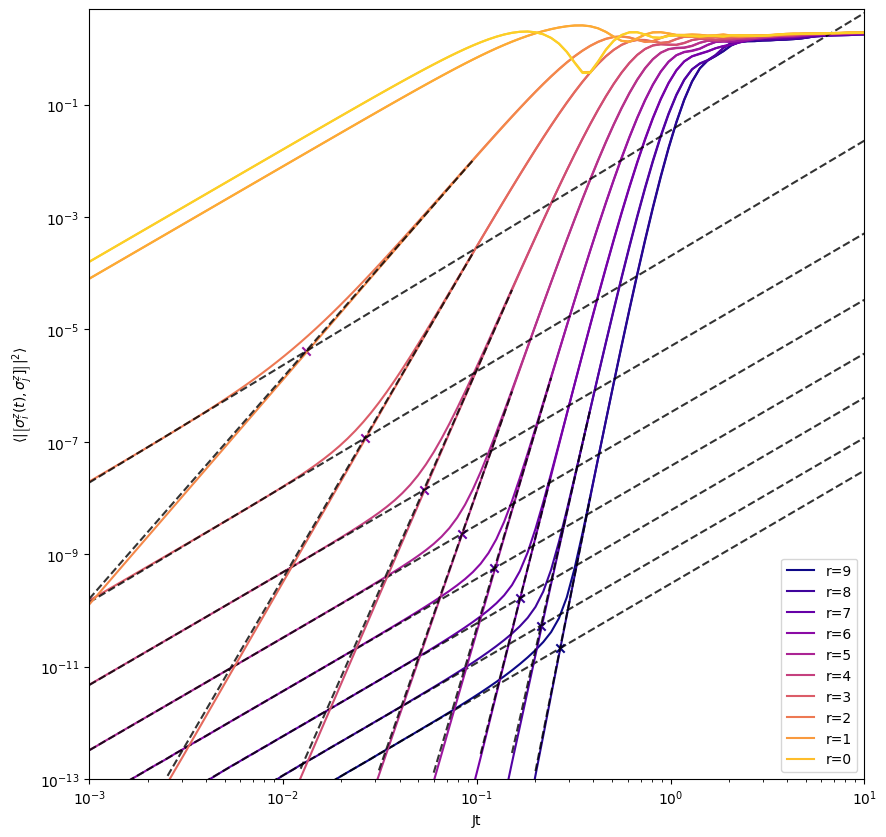

In [222]:
NUM_COLORS = N+2
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
ax.set_xscale("log")
ax.set_yscale("log")
for j in range(0,N//2+1):
    ax.plot(T,red_xx[:,j],label="r={}".format(rvals[j]))
    ax.plot(T,red_xx_nn[:,j])
    if j <= 7:
        ax.plot(T[tfitmin[j]:],model(T[tfitmin[j]:],popt[j][0],popt[j][1]),color="black",alpha=0.8,ls="dashed")
        ax.plot(T[tfitmin_nn[j]:tfitmax_nn[j]],model(T[tfitmin_nn[j]:tfitmax_nn[j]],popt_nn[j][0],popt_nn[j][1]),color="black",alpha=0.8,ls="dashed")
        ax.scatter(tcut[j],model(tcut[j],popt[j][0],popt[j][1]),marker="x")
ax.legend(loc="lower right")
ax.set_xlabel("Jt")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_xlim(1e-3,10)
ax.set_ylim(1e-13,5)
plt.show()

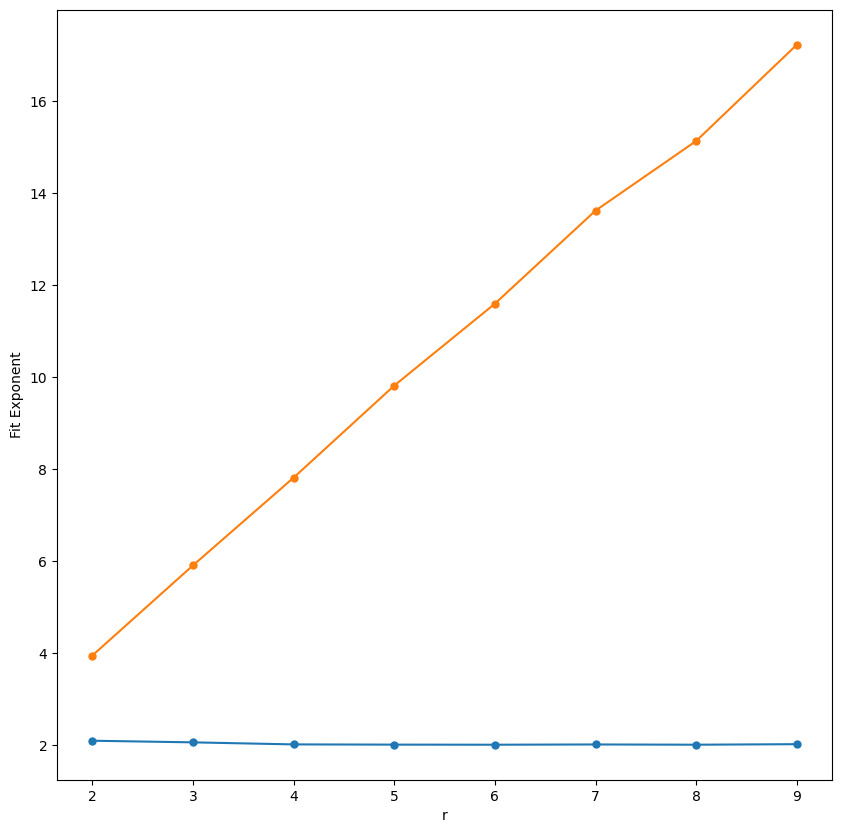

In [223]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rvals[0:8],[popt[j][1] for j in range(0,8)],marker="o",ms=5)
ax.plot(rvals[0:8],[popt_nn[j][1] for j in range(0,8)],marker="o",ms=5)
ax.set_ylabel("Fit Exponent")
ax.set_xlabel("r")
plt.show()

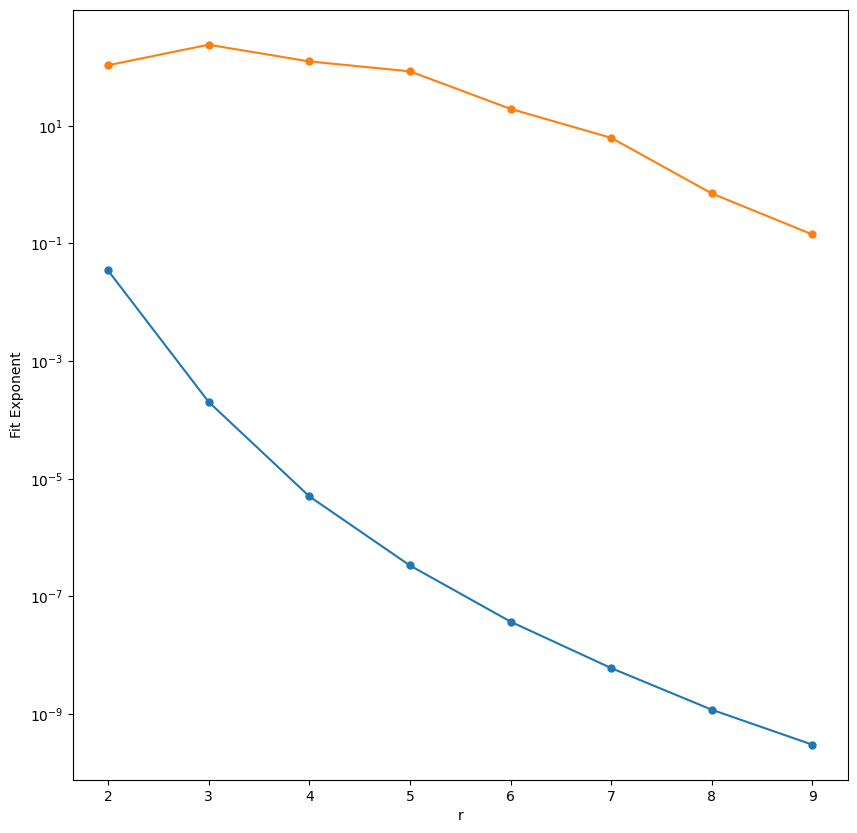

In [225]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rvals[0:8],[popt[j][0] for j in range(0,8)],marker="o",ms=5)
ax.plot(rvals[0:8],[popt_nn[j][0] for j in range(0,8)],marker="o",ms=5)
ax.set_ylabel("Fit Exponent")
ax.set_yscale("log")
ax.set_xlabel("r")
plt.show()

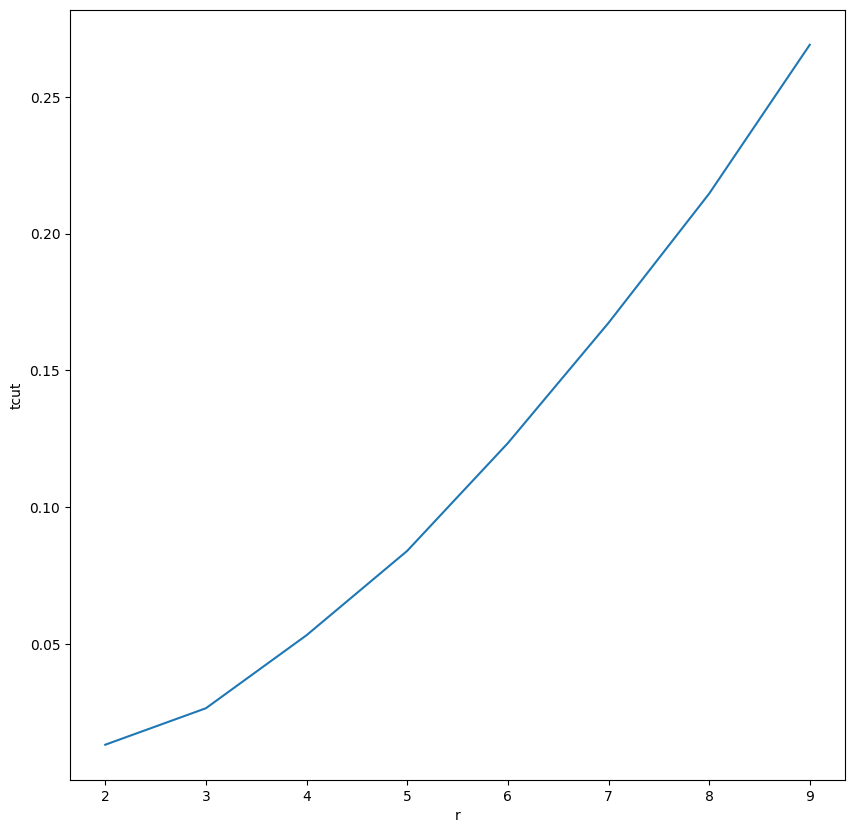

In [233]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(rvals[0:8],tcut)
ax.set_ylabel("tcut")
ax.set_xlabel("r")
plt.show()

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

## Spatial

/tmp/ipykernel_55151/1250024314.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0,N//2)


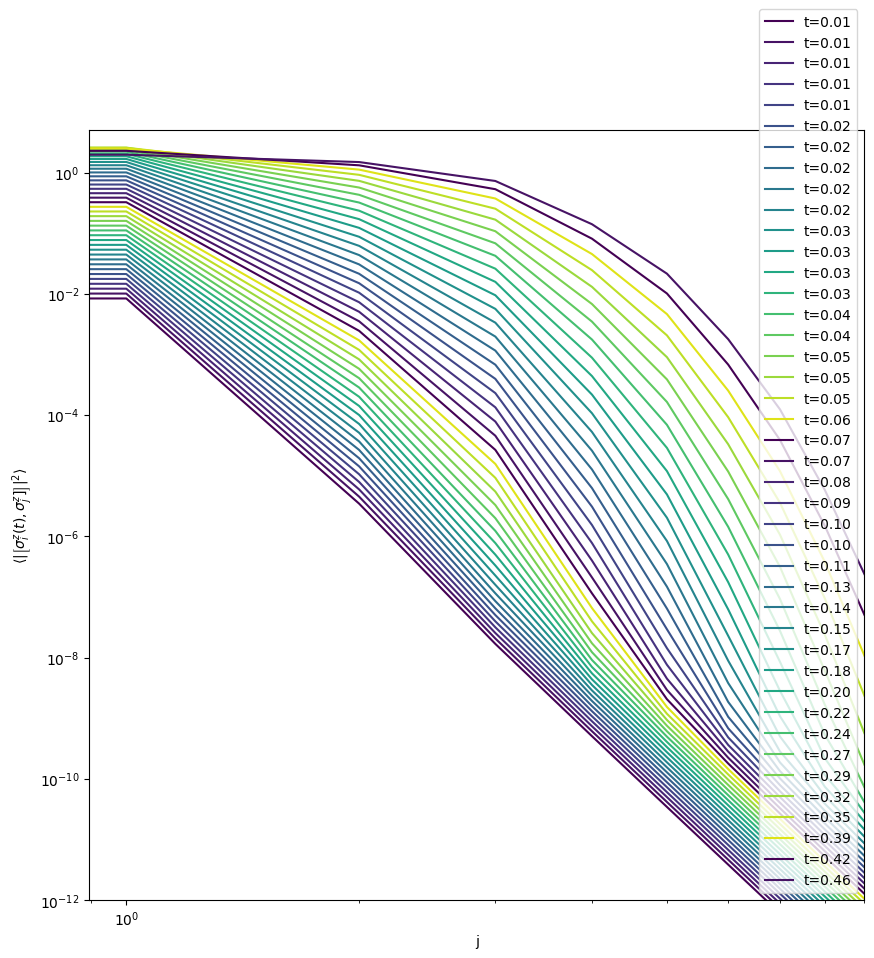

In [251]:
NUM_COLORS = N+1
cm = plt.get_cmap('viridis')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for ti,t in enumerate(T):
    if t >= 0.01 and t<= 0.5:
        ax.semilogy(rvals[0:10],red_xx[ti,:],label="t={:.2f}".format(t))
ax.legend(loc="lower right")
ax.set_xlabel("j")
ax.set_xscale("log")
ax.set_ylabel(r"$\langle\left|\left[\sigma_i^z(t),\sigma_j^z]\right]\right|^2\rangle$")
ax.set_ylim(1e-12,5)
ax.set_xlim(0,N//2)
plt.show()

In [243]:
tcut

array([0.26906347, 0.21461092, 0.16734828, 0.1233778 , 0.08398187,
       0.05313875, 0.02643366, 0.01309425])